# Labolatorium 2



## Konfiguracja z interfejsem


In [1]:
# Narzędzie jest oparte o kilka zewnętrznych bibliotek, które potrzebujemy najpierw zaimportować.
from cmath import cos, sin, pi
from turtle import color
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js
from random import uniform, random
# Parametr określający jak blisko (w odsetku całego widocznego zakresu) punktu początkowego 
# wielokąta musimy kliknąć, aby go zamknąć.
TOLERANCE = 0.15

def dist(point1, point2):
    return np.sqrt(np.power(point1[0] - point2[0], 2) + np.power(point1[1] - point2[1], 2))

# Klasa ta trzyma obecny stan wykresu oraz posiada metody, które mają zostać wykonane
# po naciśnięciu przycisków.
class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []
        self.adding_rects = False
        self.added_rects = []

    def set_axes(self, ax):
        self.ax = ax
        
    # Metoda ta obsługuje logikę przejścia do następnej sceny.
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    # Metoda ta obsługuje logikę powrotu do poprzedniej sceny.
    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    # Metoda ta aktywuje funkcję rysowania punktów wyłączając równocześnie rysowanie 
    # odcinków i wielokątów.
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.adding_rects = False
            self.added_points.append(PointsCollection([]))
            
    # Metoda ta aktywuje funkcję rysowania odcinków wyłączając równocześnie
    # rysowanie punktów i wielokątów.     
    def add_line(self, event):   
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.adding_rects = False
            self.added_lines.append(LinesCollection([]))

    # Metoda ta aktywuje funkcję rysowania wielokątów wyłączając równocześnie
    # rysowanie punktów i odcinków.
    def add_rect(self, event):
        self.adding_rects = not self.adding_rects
        self.new_line_point = None
        if self.adding_rects:
            self.adding_points = False
            self.adding_lines = False
            self.new_rect()
    
    def new_rect(self):
        self.added_rects.append(LinesCollection([]))
        self.rect_points = []
        
    # Metoda odpowiedzialna za właściwą logikę rysowania nowych elementów. W
    # zależności od włączonego trybu dodaje nowe punkty, początek, koniec odcinka
    # lub poszczególne wierzchołki wielokąta. Istnieje ciekawa logika sprawdzania
    # czy dany punkt jest domykający dla danego wielokąta. Polega ona na tym, że
    # sprawdzamy czy odległość nowego punktu od początkowego jest większa od
    # średniej długości zakresu pomnożonej razy parametr TOLERANCE.   
    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        elif self.adding_rects:
            if len(self.rect_points) == 0:
                self.rect_points.append(new_point)
            elif len(self.rect_points) == 1:
                self.added_rects[-1].add([self.rect_points[-1], new_point])
                self.rect_points.append(new_point)
                self.draw(autoscaling = False)
            elif len(self.rect_points) > 1:
                if dist(self.rect_points[0], new_point) < (np.mean([self.ax.get_xlim(), self.ax.get_ylim()])*TOLERANCE):
                    self.added_rects[-1].add([self.rect_points[-1], self.rect_points[0]])
                    self.new_rect()
                else:    
                    self.added_rects[-1].add([self.rect_points[-1], new_point])
                    self.rect_points.append(new_point)
                self.draw(autoscaling = False)
    
    # Metoda odpowiedzialna za narysowanie całego wykresu. Warto zauważyć,
    # że zaczyna się ona od wyczyszczenia jego wcześniejszego stanu. Istnieje w
    # niej nietrywialna logika zarządzania zakresem wykresu, tak żeby, w zależności
    # od ustawionego parametru autoscaling, uniknąć sytuacji, kiedy dodawanie
    # nowych punktów przy brzegu obecnie widzianego zakresu powoduje niekorzystne
    # przeskalowanie.
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines + self.added_rects):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()
# Klasa Scene odpowiada za przechowywanie elementów, które mają być
# wyświetlane równocześnie. Konkretnie jest to lista PointsCollection i
# LinesCollection.
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

# Klasa PointsCollection gromadzi w sobie punkty jednego typu, a więc takie,
# które zostaną narysowane w takim samym kolorze i stylu. W konstruktorze
# przyjmuje listę punktów rozumianych jako pary współrzędnych (x, y). Parametr
# kwargs jest przekazywany do wywołania funkcji z biblioteki MatPlotLib przez
# co użytkownik może podawać wszystkie parametry tam zaproponowane.        
class PointsCollection:
    def __init__(self, points, **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

# Klasa LinesCollection podobnie jak jej punktowy odpowiednik gromadzi
# odcinki tego samego typu. Tworząc ją należy podać listę linii, gdzie każda
# z nich jest dwuelementową listą punktów – par (x, y). Parametr kwargs jest
# przekazywany do wywołania funkcji z biblioteki MatPlotLib przez co użytkownik
# może podawać wszystkie parametry tam zaproponowane.
class LinesCollection:
    def __init__(self, lines, **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)

# Klasa Plot jest najważniejszą klasą w całym programie, ponieważ agreguje
# wszystkie przygotowane sceny, odpowiada za stworzenie wykresu i przechowuje
# referencje na przyciski, dzięki czemu nie będą one skasowane podczas tzw.
# garbage collectingu.
class Plot:
    def __init__(self, scenes = [Scene()], points = [], lines = [], json = None):
        if json is None:
            self.scenes = scenes
            if points or lines:
                self.scenes[0].points = points
                self.scenes[0].lines = lines
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
    
    # Ta metoda ma szczególne znaczenie, ponieważ konfiguruje przyciski i
    # wykonuje tym samym dość skomplikowaną logikę. Zauważmy, że konfigurując każdy
    # przycisk podajemy referencję na metodę obiektu _Button_callback, która
    # zostanie wykonana w momencie naciśnięcia.
    def __configure_buttons(self):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        ax_add_rect = plt.axes([0.12, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(self.callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(self.callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(self.callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(self.callback.add_line)
        b_add_rect = Button(ax_add_rect, 'Dodaj figurę')
        b_add_rect.on_clicked(self.callback.add_rect)
        return [b_prev, b_next, b_add_point, b_add_line, b_add_rect]
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes

    # Metoda toJson() odpowiada za zapisanie stanu obiektu do ciągu znaków w
    # formacie JSON.
    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])    
    
    # Metoda ta zwraca punkty dodane w trakcie rysowania.
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
    
    # Metoda ta zwraca odcinki dodane w trakcie rysowania.
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
        
    # Metoda ta zwraca wielokąty dodane w trakcie rysowania.
    def get_added_figure(self):
        if self.callback:
            return self.callback.added_rects
        else:
            return None
    
    # Metoda ta zwraca punkty, odcinki i wielokąty dodane w trakcie rysowania
    # jako scenę.
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines+self.callback.added_rects)
        else:
            return None
    
    # Główna metoda inicjalizująca wyświetlanie wykresu.
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons()
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()


### Potrzebne importy w rozwiązywaniu zadań


In [2]:
import random
import time
import copy

### Zestaw danych I

<IPython.core.display.Javascript object>


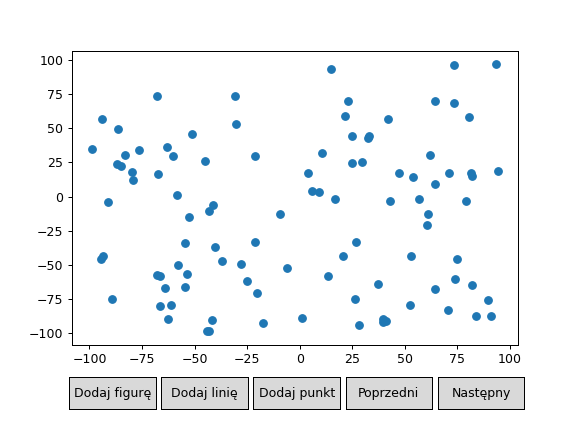

In [3]:
%matplotlib notebook
def ex1a(numPoints, rangePoints, ifDraw = True):
    listOfPoints1 = [(random.uniform(rangePoints[0],rangePoints[1]),random.uniform(rangePoints[0],rangePoints[1])) for _ in range(numPoints)]
    if ifDraw:
        points1 = PointsCollection(listOfPoints1)
        plot1 = Plot(points=[points1])
        plot1.draw()
    return listOfPoints1
listOfPoints1 = ex1a(100, (-100,100))

### Zestaw danych II

<IPython.core.display.Javascript object>


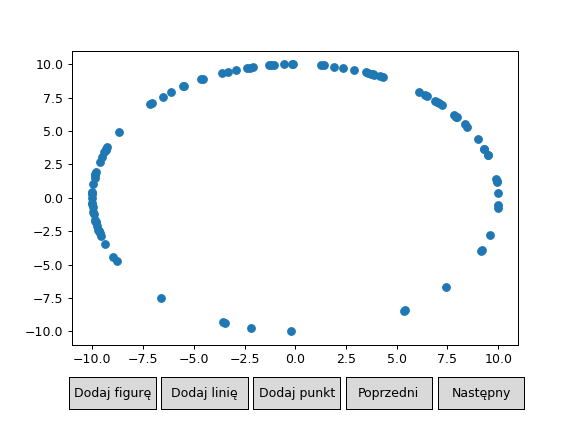

In [4]:
def ex1b(numPoints, center, radius, ifDraw = True):
    r = radius
    listOfPoints2 = []
    for _ in range(numPoints):
        t = random.random() * (np.pi*2)
        listOfPoints2.append((r * np.cos(np.pi/2 * t) + center[0], r * np.sin(np.pi/2 * t) + center[1]))
    if ifDraw:
        points2 = PointsCollection(listOfPoints2)
        plot2 = Plot(points=[points2])
        plot2.draw()
    return listOfPoints2

listOfPoints2 = ex1b(100, (0, 0), 10)


### Zestaw danych III

<IPython.core.display.Javascript object>


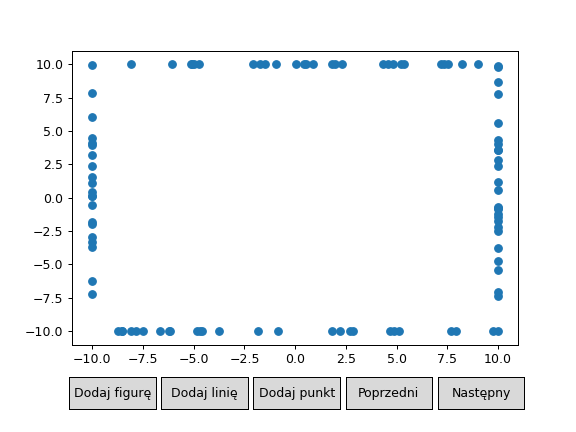

In [5]:
def ex1c(numPoints, vertexRect, ifDraw = True):
    listOfChoices = ["[-1,random]","[random,-1]","[random,1]","[1,random]"] 
    listOfPoints3 = []
    #  vertexRect = (-10, 10), (-10,-10), (10,-10), (10,10)
    for _ in range(numPoints):
        myChoice = random.choice(listOfChoices)
        if myChoice == "[1,random]":
            listOfPoints3.append((vertexRect[2][0],random.uniform(vertexRect[2][1],vertexRect[3][1])))
        elif myChoice == "[-1,random]":
            listOfPoints3.append((vertexRect[0][0],random.uniform(vertexRect[1][1],vertexRect[0][1])))
        elif myChoice == "[random,1]":
            listOfPoints3.append((random.uniform(vertexRect[0][0],vertexRect[3][0]),vertexRect[0][1]))
        else:
            listOfPoints3.append((random.uniform(vertexRect[1][0],vertexRect[2][0]),vertexRect[1][1]))
    if ifDraw:
        points3 = PointsCollection(listOfPoints3)
        plot3 = Plot(points=[points3])
        plot3.draw()
    return listOfPoints3
listOfPoints3 = ex1c(100, [(-10, 10), (-10,-10), (10,-10), (10,10)])

### Zestaw danych IV

<IPython.core.display.Javascript object>


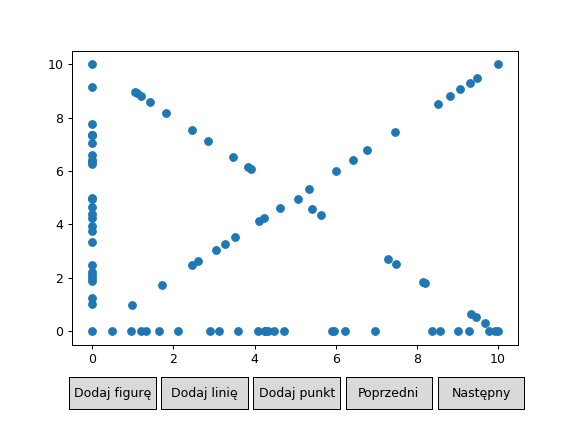

In [6]:
def ex1d(vertexSqr, pointsOnAxis, pointsOnDiagonal, ifDraw = True):
    listOfPoints4 = vertexSqr

    # vertexSqr = (0, 0), (10, 0), (10, 10), (0, 10)

    # axis y
    i = 0
    while i < pointsOnAxis:
        k = (vertexSqr[0][0],random.uniform(vertexSqr[0][1],vertexSqr[3][1]))
        if k in vertexSqr:
            continue
        
        listOfPoints4.append(k)
        i += 1
    
    # axis x
    i = 0
    while i < pointsOnAxis:
        k = (random.uniform(vertexSqr[0][0],vertexSqr[1][0]), vertexSqr[0][1])
        if k in vertexSqr:
            continue
        
        listOfPoints4.append(k)
        i += 1

    #growing diagonal
    i = 0
    while i < pointsOnDiagonal:
        randK = random.uniform(vertexSqr[0][0],vertexSqr[1][0])
        k = (randK, randK)
        if k in vertexSqr:
            continue
        listOfPoints4.append(k)
        i += 1

    #falling diagonal
    i = 0
    while i < pointsOnDiagonal:
        randK = random.uniform(vertexSqr[0][0],vertexSqr[1][0])
        k = (randK, vertexSqr[3][1] - randK)
        if k in vertexSqr:
            continue
        
        listOfPoints4.append(k)
        i += 1
    if ifDraw:
        points4 = PointsCollection(listOfPoints4)
        plot4 = Plot(points=[points4])
        plot4.draw()
    return listOfPoints4

listOfPoints4 = ex1d([(0, 0), (10, 0), (10, 10), (0, 10)], 25, 20)

## Algorytm Grahama

In [7]:
epsilon = 10e-12
def grahamAlgorithm(points_pass, ifDraw = True):
    time_start = time.process_time()
    p0 = min(points_pass, key=lambda x: (x[1],x[0]))   

    def distance(a, b):
        return np.sqrt((a[0]-b[0])**2 + (a[1]-b[1])**2)

    def orient(p,q,r):
        result = ((p[0] - r[0])*(q[1] - r[1]) - (p[1] - r[1])*(q[0] - r[0]))
        if result > epsilon:
            return 1
        elif result < -epsilon:
            return -1
        else:
            return 0

    def partition(A,p,r):
        x = A[r]
        i = p-1
        for j in range(p,r):
            result = orient(p0, A[j], x)
            if result == 1 or (result == 0 and distance(p0, A[j]) > distance(p0, x)):
                i+=1
                A[i],A[j] = A[j],A[i]

        A[i+1],A[r] = A[r],A[i+1]
        return i+1

    def quicksort(A,p,r):
        if len(A) == 1:
            return A
        if p < r:
            q = partition(A,p,r)
            quicksort(A,p,q-1)
            quicksort(A,q+1,r)

    scenes = []
    points = points_pass.copy()

    points.remove(p0)

    quicksort(points, 0, len(points)-1)

    points = [p0] + points

    stack = []
    stack.append(points[0])
    stack.append(points[1])
    stack.append(points[2])
    if ifDraw:
        scenes.append(Scene([PointsCollection(points), PointsCollection(stack.copy(),color = "black")],
                                [LinesCollection([(stack[0],stack[1]),(stack[1],stack[2])], color="green")]))
    i = 3
    while i < len(points):
        if ifDraw:
            points_of_stack = [(stack[i], stack[i+1]) for i in range(len(stack) - 1)]
            scenes.append(Scene([PointsCollection(points), PointsCollection(stack.copy(),color = "black"), PointsCollection([points[i]], color = "green")],
                                [LinesCollection(points_of_stack, color="red"), LinesCollection([(points[i],stack[-1])], color = "green")]))
        
        if orient(stack[-2], stack[-1], points[i]) == 1:
            stack.append(points[i])
            i = i + 1
        elif orient(stack[-2], stack[-1], points[i]) == 0:
            stack.pop()
            stack.append(points[i])
            i = i + 1
        else:
            stack.pop()
    
    if orient(stack[-2], stack[-1], p0) == 0:
        stack.pop()

    points_of_stack = [(stack[i], stack[i+1]) for i in range(len(stack) - 1)]
    if ifDraw:
        scenes.append(Scene([PointsCollection(points), PointsCollection(stack.copy(),color = "black"), PointsCollection([p0], color = "black")],
                                [LinesCollection(points_of_stack, color="red"), LinesCollection([(p0,stack[-1])], color = "green")]))

        linesFinals = [(stack[i],stack[i+1]) for i in range(len(stack) - 1)]
        linesFinals.append([stack[-1],stack[0]])
        begin = list(map(lambda x: (p0, x), points_pass))
        beginScene = Scene([PointsCollection(points)], [LinesCollection(begin)])
        finalScene = Scene([PointsCollection(points), PointsCollection(stack, color = "red")], [LinesCollection(linesFinals, color = "red")])

        scenes = [finalScene, beginScene] + scenes 

        return (stack, time.process_time() - time_start, scenes)
    
    return (stack, time.process_time() - time_start)



### Poprawiony algorytm Grahama w implementacji z dodatkowo dokładym mierzeniem czasu działania (czas działania jest mierzony na procesorze)

In [8]:
def grahamAlgorithmUpgrade(points_pass):
    time_start = time.process_time()
    p0 = min(points_pass, key=lambda x: (x[1],x[0]))   

    def distance(a, b):
        return np.sqrt((a[0]-b[0])**2 + (a[1]-b[1])**2)

    def orient(p,q,r):
        result = ((p[0] - r[0])*(q[1] - r[1]) - (p[1] - r[1])*(q[0] - r[0]))
        if result > epsilon:
            return 1
        elif result < -epsilon:
            return -1
        else:
            return 0

    def partition(A,p,r):
        x = A[r]
        i = p-1
        for j in range(p,r):
            result = orient(p0, A[j], x)
            if result == 1 or (result == 0 and distance(p0, A[j]) > distance(p0, x)):
                i+=1
                A[i],A[j] = A[j],A[i]

        A[i+1],A[r] = A[r],A[i+1]
        return i+1

    def quicksort(A,p,r):
        if len(A) == 1:
            return A
        if p < r:
            q = partition(A,p,r)
            quicksort(A,p,q-1)
            quicksort(A,q+1,r)

    points = points_pass.copy()

    points.remove(p0)

    quicksort(points, 0, len(points)-1)

    points = [p0] + points

    stack = []
    stack.append(points[0])
    stack.append(points[1])
    stack.append(points[2])

    i = 3
    while i < len(points):
        if orient(stack[-2], stack[-1], points[i]) == 1:
            
            stack.append(points[i])
            i = i + 1
        elif orient(stack[-2], stack[-1], points[i]) == 0:
            stack.pop()
            stack.append(points[i])
            i = i + 1
        else:
            stack.pop()
    
    if orient(stack[-2], stack[-1], p0) == 0:
        stack.pop()

    
    return (stack, time.process_time() - time_start)

### Czas działania i wynik dla zestawu I, II, III i IV z wykorzystanie algorytmu Grahama

--- 0.00000 s ---


<IPython.core.display.Javascript object>


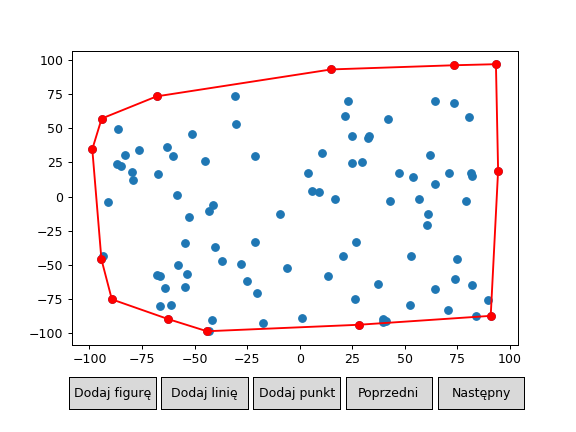

In [9]:
grah1 = grahamAlgorithm(listOfPoints1)
print("--- %.5f s ---" % grah1[1])
plot1 = Plot(scenes = grah1[2])
plot1.draw()

--- 0.00000 s ---


<IPython.core.display.Javascript object>


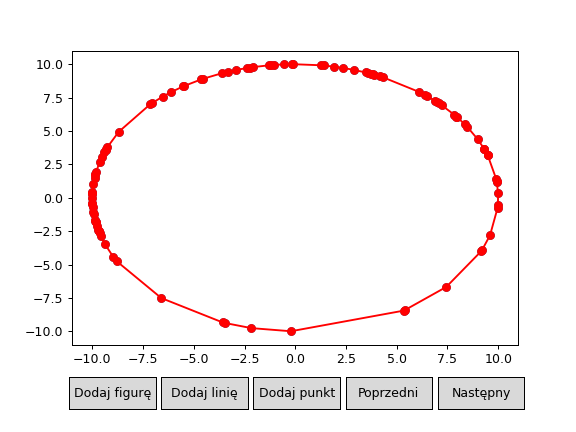

In [10]:
grah1 = grahamAlgorithm(listOfPoints2)
print("--- %.5f s ---" % grah1[1])
plot1 = Plot(scenes = grah1[2])
plot1.draw()

--- 0.00000 s ---


<IPython.core.display.Javascript object>


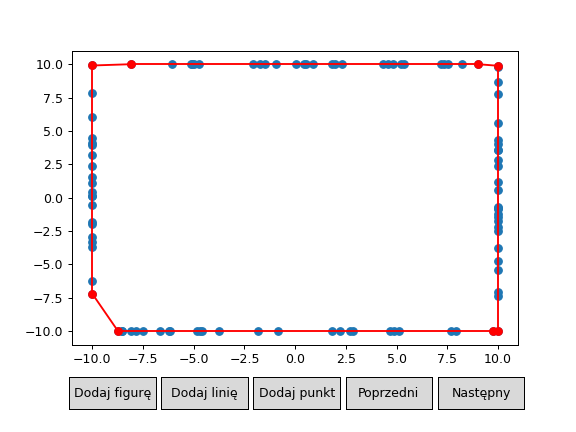

In [11]:
grah1 = grahamAlgorithm(listOfPoints3)
print("--- %.5f s ---" % grah1[1])
plot1 = Plot(scenes = grah1[2])
plot1.draw()

--- 0.00000 s ---


<IPython.core.display.Javascript object>


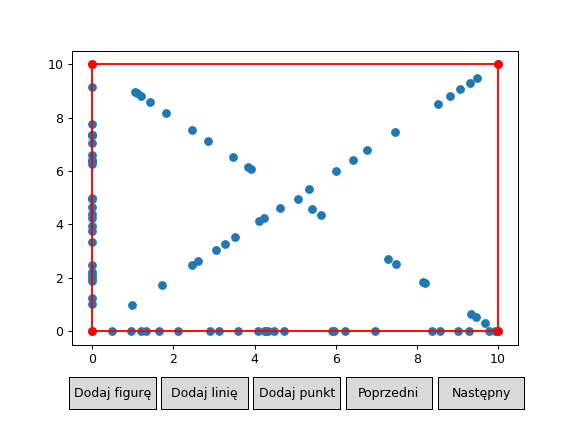

In [12]:
grah1 = grahamAlgorithm(listOfPoints4)
print("--- %.5f s ---" % grah1[1])
plot1 = Plot(scenes = grah1[2])
plot1.draw()

### Czas działania i wynik dla zestawu I, II, III i IV z wykorzystanie poprawionego algorytmu Grahama

In [13]:
grah1 = grahamAlgorithmUpgrade(listOfPoints1)
print("--- %.5f s ---" % grah1[1])

--- 0.00000 s ---


In [14]:
grah1 = grahamAlgorithmUpgrade(listOfPoints2)
print("--- %.5f s ---" % grah1[1])

--- 0.00000 s ---


In [15]:
grah1 = grahamAlgorithmUpgrade(listOfPoints3)
print("--- %.5f s ---" % grah1[1])

--- 0.01562 s ---


In [16]:
grah1 = grahamAlgorithmUpgrade(listOfPoints4)
print("--- %.5f s ---" % grah1[1])

--- 0.00000 s ---


### Czas działania i wyniki dla różnych danych wejściowych dla zestawu III z wykorzystaniem algorytmu Grahama

--- 0.01562 s ---


<IPython.core.display.Javascript object>


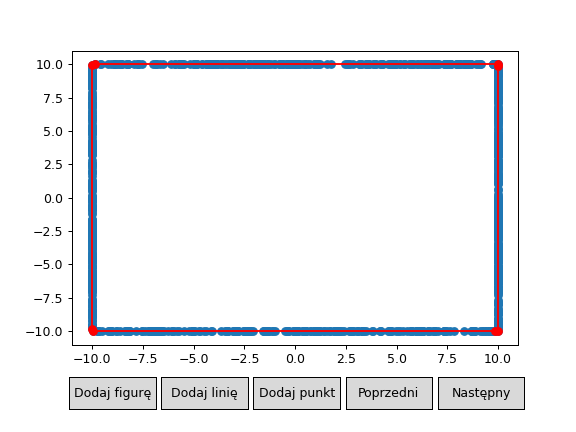

In [17]:
#  100, [(-10, 10), (-10,-10), (10,-10), (10,10)] ## numOfPoints, nodes of rectange
#                   x,  y       x,  y     x,  y     x, y
sample1 = (1000, [(-10, 10), (-10,-10), (10,-10), (10,10)])
sample2 = (1000, [(-17, 23), (-17,-15), (100,-15), (100,23)])
sample3 = (100000, [(-1111, 997), (-1111,-2137), (1000,-2137), (1000,997)])

pointsOfIII = [] 
pointsOfIII.append(ex1c(sample1[0], sample1[1], ifDraw=False))
pointsOfIII.append(ex1c(sample2[0], sample2[1], ifDraw=False))
pointsOfIII.append(ex1c(sample3[0], sample3[1], ifDraw=False))

grah1 = grahamAlgorithm(pointsOfIII[0])
print("--- %.5f s ---" % grah1[1])
plot1 = Plot(scenes = grah1[2])
plot1.draw()

--- 0.01562 s ---


<IPython.core.display.Javascript object>


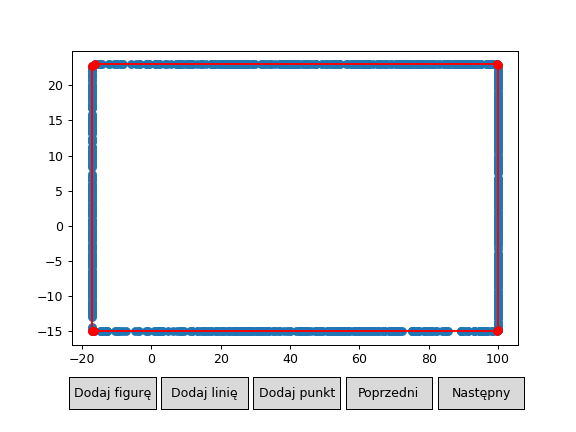

In [18]:
grah1 = grahamAlgorithm(pointsOfIII[1])
print("--- %.5f s ---" % grah1[1])
plot1 = Plot(scenes = grah1[2])
plot1.draw()

--- 5.03125 s ---


<IPython.core.display.Javascript object>


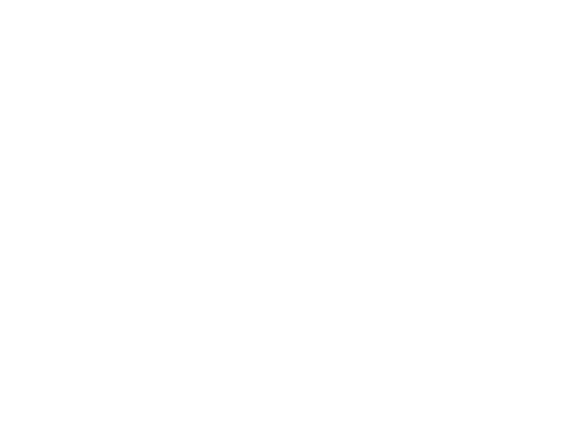

In [19]:
grah1 = grahamAlgorithm(pointsOfIII[2])
print("--- %.5f s ---" % grah1[1])
plot1 = Plot(scenes = grah1[2])
plot1.draw()

## Algorytm Jarvisa

In [20]:
def distance(a, b):
    return np.sqrt((a[0]-b[0])**2 + (a[1]-b[1])**2)

def orient(p,q,r):
        result = ((p[0] - r[0])*(q[1] - r[1]) - (p[1] - r[1])*(q[0] - r[0]))
        if result > epsilon:
            return 1
        elif result < -epsilon:
            return -1
        else:
            return 0

def jarvisAlgorithm(points_pass, ifDraw = True):
    
    time_start = time.process_time()
    p0 = min(points_pass, key=lambda x: (x[1],x[0]))

    scenes = []
    points_of_hull = [p0] # points that inculde in convex hull
    lastpoint = points_pass[0] if points_pass[0] != p0 else points_pass[1] # the latest point to check if it can be in convex hull
    curr_point = p0 # current point of convex hull

    while (True):

        for i in range(len(points_pass)):
            if ifDraw:
                points_to_draw = [(points_of_hull[j], points_of_hull[j+1]) for j in range(len(points_of_hull)-1)]
                scenes.append(Scene([PointsCollection(points_pass), PointsCollection(points_of_hull.copy(),color = "black"), PointsCollection([points_pass[i]],color = "green")],
                                [LinesCollection(points_to_draw, color="red"), LinesCollection([(points_of_hull[-1],points_pass[i])], color = "green")]))
            if (orient(curr_point, lastpoint, points_pass[i]) == -1 ) or (orient(curr_point, lastpoint, points_pass[i]) == 0 and distance(lastpoint, curr_point) < distance(curr_point, points_pass[i])):
                lastpoint = points_pass[i]
        
        curr_point = lastpoint

        if curr_point == p0:
            break
            
        points_of_hull.append(curr_point)

    if ifDraw:

        lines_of_convex_hull = [(points_of_hull[i], points_of_hull[i+1]) for i in range(len(points_of_hull)-1)]
        lines_of_convex_hull.append((points_of_hull[-1],points_of_hull[0]))
        finalScene = Scene([PointsCollection(points_pass), PointsCollection(points_of_hull, color = "red")], [LinesCollection(lines_of_convex_hull, color = "red")])
        begin = list(map(lambda x : (p0,x), points_pass))
        beginScene = Scene([PointsCollection(points_pass)], [LinesCollection(begin)])
        scenes = [beginScene, finalScene] + scenes + [finalScene]
        
        return (points_of_hull, time.process_time() - time_start, scenes)
    
    return (points_of_hull, time.process_time() - time_start)
    
                
    
    
    

### Poprawiony algorytm Jarvisa w implementacji z dodatkowo dokładym mierzeniem czasu działania (czas działania jest mierzony na procesorze)

In [21]:
def jarvisAlgorithmUpgrade(points_pass):
    
    time_start = time.process_time()
    p0 = min(points_pass, key=lambda x: (x[1],x[0]))

    points_of_hull = [p0] # points that inculde in convex hull
    lastpoint = points_pass[0] if points_pass[0] != p0 else points_pass[1] # the latest point to check if it can be in convex hull
    curr_point = p0 # current point of convex hull

    while (True):

        for i in range(len(points_pass)):
            if (orient(curr_point, lastpoint, points_pass[i]) == -1 ) or (orient(curr_point, lastpoint, points_pass[i]) == 0 and distance(lastpoint, curr_point) < distance(curr_point, points_pass[i])):
                lastpoint = points_pass[i]
        
        curr_point = lastpoint

        if curr_point == p0:
            break
            
        points_of_hull.append(curr_point)
    
    return (points_of_hull, time.process_time() - time_start)
    

### Czas działania i wynik dla zestawu I, II, III i IV z wykorzystanie algorytmu Jarvisa


--- 0.00000 s ---


<IPython.core.display.Javascript object>


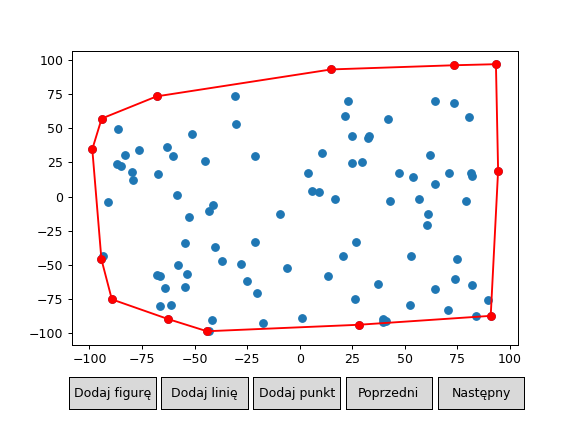

In [25]:
grah1 = jarvisAlgorithm(listOfPoints1)
print("--- %.5f s ---" % grah1[1])
plot1 = Plot(scenes = grah1[2])
plot1.draw()

--- 0.37500 s ---


<IPython.core.display.Javascript object>


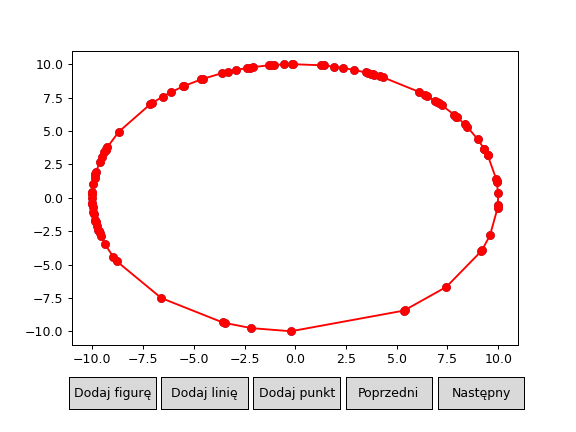

In [26]:
grah1 = jarvisAlgorithm(listOfPoints2)
print("--- %.5f s ---" % grah1[1])
plot1 = Plot(scenes = grah1[2])
plot1.draw()

--- 0.12500 s ---


<IPython.core.display.Javascript object>


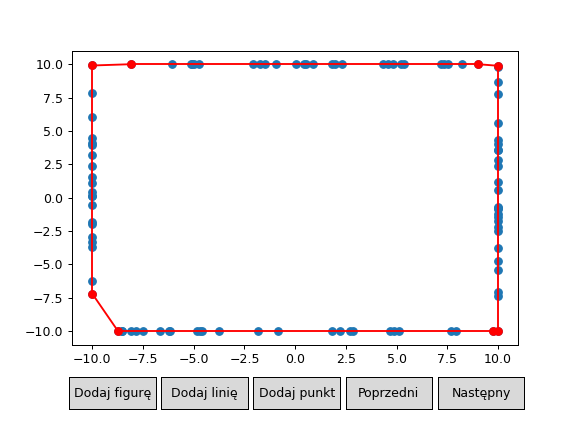

In [27]:
grah1 = jarvisAlgorithm(listOfPoints3)
print("--- %.5f s ---" % grah1[1])
plot1 = Plot(scenes = grah1[2])
plot1.draw()

--- 0.00000 s ---


<IPython.core.display.Javascript object>


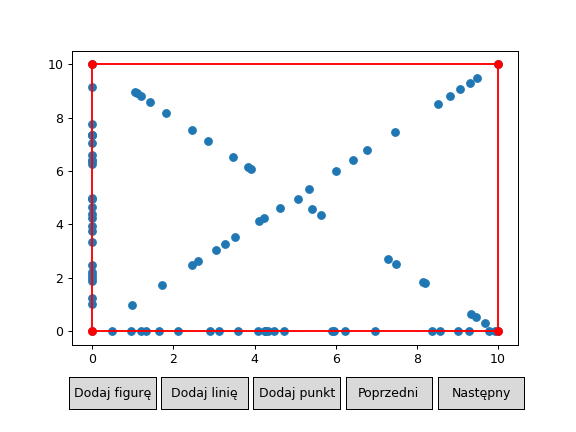

In [28]:
grah1 = jarvisAlgorithm(listOfPoints4)
print("--- %.5f s ---" % grah1[1])
plot1 = Plot(scenes = grah1[2])
plot1.draw()

### Czas działania i wyniki dla różnych danych wejściowych dla zestawu III z wykorzystaniem algorytmu Jarvisa

--- 0.18750 s ---


<IPython.core.display.Javascript object>


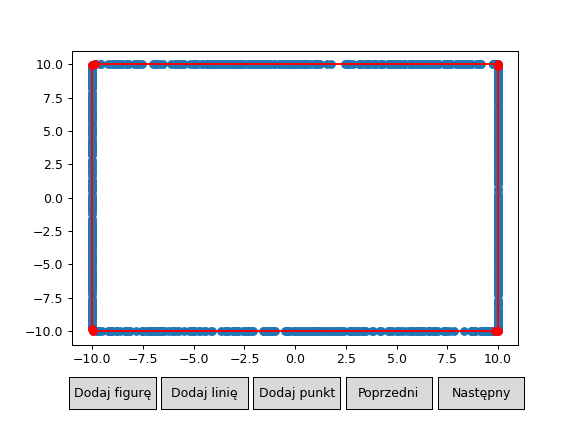

In [29]:
grah1 = jarvisAlgorithm(pointsOfIII[0])
print("--- %.5f s ---" % grah1[1])
plot1 = Plot(scenes = grah1[2])
plot1.draw()

--- 0.26562 s ---


<IPython.core.display.Javascript object>


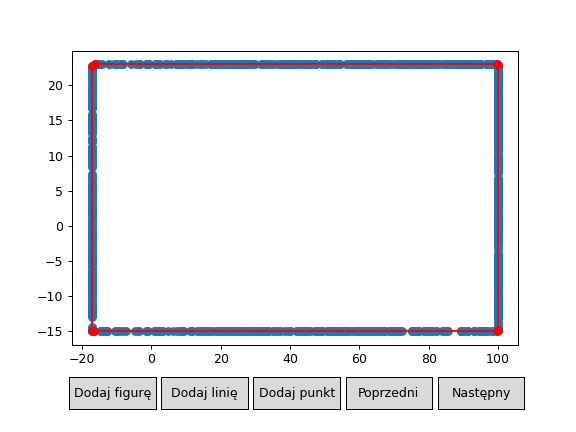

In [30]:
grah1 = jarvisAlgorithm(pointsOfIII[1])
print("--- %.5f s ---" % grah1[1])
plot1 = Plot(scenes = grah1[2])
plot1.draw()

--- 22.04688 s ---


<IPython.core.display.Javascript object>


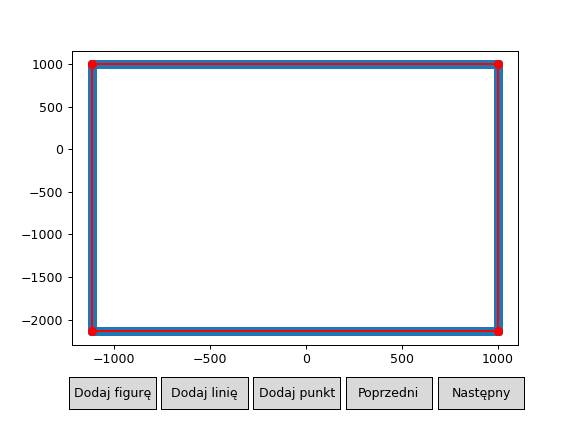

In [31]:
grah1 = jarvisAlgorithm(pointsOfIII[2])
print("--- %.5f s ---" % grah1[1])
plot1 = Plot(scenes = grah1[2])
plot1.draw()

In [32]:
grah1 = jarvisAlgorithmUpgrade(pointsOfIII[2])
print("--- %.5f s ---" % grah1[1])

--- 1.09375 s ---


### Funkcja sprawdzająca i porównująca, dla różnych ilości punktów, czas działa algorytmu Grahama i Jarvisa na wszystkich zbiorach danych

In [33]:
def executingTime():
    amount = [10, 100, 1000, 5000, 10000, 25000, 50000]

    jarvisExe = []
    grahamExe = []
    
    grahamExe.append([(amount[i] ,grahamAlgorithmUpgrade(ex1a(amount[i], (-amount[2],amount[2]), ifDraw=False))[1]) for i in range(len(amount))])
    # print("OK") - to show in what state algorithm is / it might to execute without print("OK")
    grahamExe.append([(amount[i] ,grahamAlgorithmUpgrade(ex1b(amount[i], (0, 0), amount[2], ifDraw=False))[1]) for i in range(len(amount))])
    # print("OK")
    grahamExe.append([(amount[i] ,grahamAlgorithmUpgrade(ex1c(amount[i], [(-amount[2], amount[2]), (-amount[2],-amount[2]), (amount[2],-amount[2]), (amount[2],amount[2])], ifDraw=False))[1]) for i in range(len(amount))])
    # print("OK")
    grahamExe.append([(amount[i] ,grahamAlgorithmUpgrade(ex1d([(0, 0), (amount[2], 0), (amount[2], amount[2]), (0, amount[2])], amount[i]//2, amount[i]//2, ifDraw=False))[1]) for i in range(len(amount))])
    # print("OK")

    jarvisExe.append([(amount[i] ,jarvisAlgorithmUpgrade(ex1a(amount[i], (-amount[2],amount[2]), ifDraw=False))[1]) for i in range(len(amount))])
    # print("OK")
    jarvisExe.append([(amount[i] ,jarvisAlgorithmUpgrade(ex1b(amount[i], (0, 0), amount[2], ifDraw=False))[1]) for i in range(len(amount))])
    # print("OK")
    jarvisExe.append([(amount[i] ,jarvisAlgorithmUpgrade(ex1c(amount[i], [(-amount[2], amount[2]), (-amount[2],-amount[2]), (amount[2],-amount[2]), (amount[2],amount[2])], ifDraw=False))[1]) for i in range(len(amount))])
    # print("OK")
    jarvisExe.append([(amount[i] ,jarvisAlgorithmUpgrade(ex1d([(0, 0), (amount[2], 0), (amount[2], amount[2]), (0, amount[2])], amount[i]//2, amount[i]//2, ifDraw=False))[1]) for i in range(len(amount))])
    # print("OK")



    for i in range(len(jarvisExe)): # go through all plots
        print("Dla zbioru danych %d:" %(i+1))
        for j in range(len(jarvisExe[0])): # go through all amount of points
            print("     Dla liczby punktów: %d:" %amount[j])
            print("        Jarvis: %.5f s" %jarvisExe[i][j][1])
            print("        Graham: %.5f s" %grahamExe[i][j][1])
            




In [125]:
executingTime()

OK
OK
OK
OK
OK
OK
OK
OK
Dla zbioru danych 1:
     Dla liczby punktów: 10:
        Jarvis: 0.00035 s
        Graham: 0.00007 s
     Dla liczby punktów: 100:
        Jarvis: 0.00080 s
        Graham: 0.00089 s
     Dla liczby punktów: 1000:
        Jarvis: 0.00990 s
        Graham: 0.01192 s
     Dla liczby punktów: 5000:
        Jarvis: 0.08350 s
        Graham: 0.07248 s
     Dla liczby punktów: 10000:
        Jarvis: 0.14797 s
        Graham: 0.08177 s
     Dla liczby punktów: 25000:
        Jarvis: 0.56808 s
        Graham: 0.20651 s
     Dla liczby punktów: 50000:
        Jarvis: 0.84822 s
        Graham: 0.48260 s
Dla zbioru danych 2:
     Dla liczby punktów: 10:
        Jarvis: 0.00019 s
        Graham: 0.00005 s
     Dla liczby punktów: 100:
        Jarvis: 0.01223 s
        Graham: 0.00054 s
     Dla liczby punktów: 1000:
        Jarvis: 1.15087 s
        Graham: 0.00911 s
     Dla liczby punktów: 5000:
        Jarvis: 29.45612 s
        Graham: 0.05343 s
     Dla liczby punktów

### Funkcja pozwalająca na zapisanie do pliku wszystkich punktów zawierających się w otoczce wypukłej danego zbioru punktów

In [29]:
def saveToFile(points):
    with open('pointsOfConvexHull.txt', 'w') as file:
        file.write("".join(str(points[i])+"\n" for i in range(len(points))) )


In [283]:
saveToFile(listOfPoints1)